In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()

In [3]:
df = pd.read_csv('../dataset/pp_kospi.csv')
df.head()

,일자,종가
0,2017-01-02,2026.16
1,2017-01-03,2043.97
2,2017-01-04,2045.64
3,2017-01-05,2041.95
4,2017-01-06,2049.12


In [4]:
adj_close_idx = 1
df_adj_close = df.iloc[:, adj_close_idx:adj_close_idx+1].astype('float32')
minmax = MinMaxScaler().fit(df_adj_close) # Adj Close MinMaxScaler
normalized_adj_close = minmax.transform(df_adj_close) # Normalized Adj Close (np.array)

In [5]:
test_size = 60

train_data = normalized_adj_close[:-test_size]
eval_data = normalized_adj_close[-test_size:]
train_data.shape, eval_data.shape

((1415, 1), (60, 1))

In [6]:
import torch

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # macbook

In [7]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        return self.data[idx:idx+self.seq_len], self.data[idx+self.seq_len]
    
seq_len = 20
train_dataset = StockDataset(train_data, seq_len)
eval_dataset = StockDataset(eval_data, seq_len)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

In [9]:
def train(epochs, model, trn_loader, criterion, optimizer):
    pbar = tqdm(range(epochs))
    total_loss = []
    for epoch in pbar:
        for seq, labels in trn_loader:
            seq = seq.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
        pbar.set_postfix(loss = np.mean(total_loss))

In [10]:
def eval(model, evl_loader):
    model.eval()
    with torch.no_grad():
        preds = []
        labels = []
        for seq, label in evl_loader:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            preds.append(y_pred.item())
            labels.append(label.item())
    return preds, labels

In [11]:
input_dim = 1
hidden_dim = 128
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
train(num_epochs, model, train_loader, criterion, optimizer)

100%|██████████| 100/100 [00:57<00:00,  1.75it/s, loss=0.000894]


In [13]:
eval(model, eval_loader)

([0.4681490659713745,
  0.4781259000301361,
  0.49242737889289856,
  0.5073562264442444,
  0.5211612582206726,
  0.5086541771888733,
  0.5509628653526306,
  0.550469160079956,
  0.5492384433746338,
  0.5485464334487915,
  0.5292194485664368,
  0.5291383862495422,
  0.5171242952346802,
  0.5082728862762451,
  0.5160220861434937,
  0.5300436615943909,
  0.528132438659668,
  0.5104517936706543,
  0.5234793424606323,
  0.5473981499671936,
  0.5513319969177246,
  0.5245378613471985,
  0.5148175358772278,
  0.5020243525505066,
  0.495937705039978,
  0.49043557047843933,
  0.5004366040229797,
  0.4929657280445099,
  0.49085700511932373,
  0.5063064694404602,
  0.48649096488952637,
  0.4827865958213806,
  0.4805097281932831,
  0.46997082233428955,
  0.46701133251190186,
  0.4831244945526123,
  0.46129223704338074,
  0.4593569040298462,
  0.4703871011734009,
  0.4427003264427185],
 [0.482141375541687,
  0.4947850704193115,
  0.5095341205596924,
  0.5232656002044678,
  0.5112607479095459,
  0.55

In [14]:
def forcast(future_day):
    
    model.eval()
    output_predict = np.zeros((train_data.shape[0] + future_day, train_data.shape[1]))
    output_predict[:seq_len] = train_data[:seq_len]

    for k in range(train_data.shape[0]):
        out_logits = model(torch.Tensor(train_data[k : k + seq_len]).unsqueeze(0).to(device))
        output_predict[k + seq_len] = out_logits.detach().numpy()

    for i in range(future_day):
        o = output_predict[-future_day - seq_len + i:-future_day + i]
        out_logits = model(torch.Tensor(o).unsqueeze(0).to(device))
        output_predict[-future_day + i] = out_logits.detach().numpy()

    unnormalized_output_predict = minmax.inverse_transform(output_predict)

    return unnormalized_output_predict

In [15]:
predict = forcast(test_size)

In [16]:
def calculate_accuracy(real, predict):
    real = torch.tensor(real) + 1
    predict = torch.tensor(predict) + 1
    percentage = 1 - torch.sqrt(torch.mean(torch.square((real - predict) / real)))
    return percentage * 100

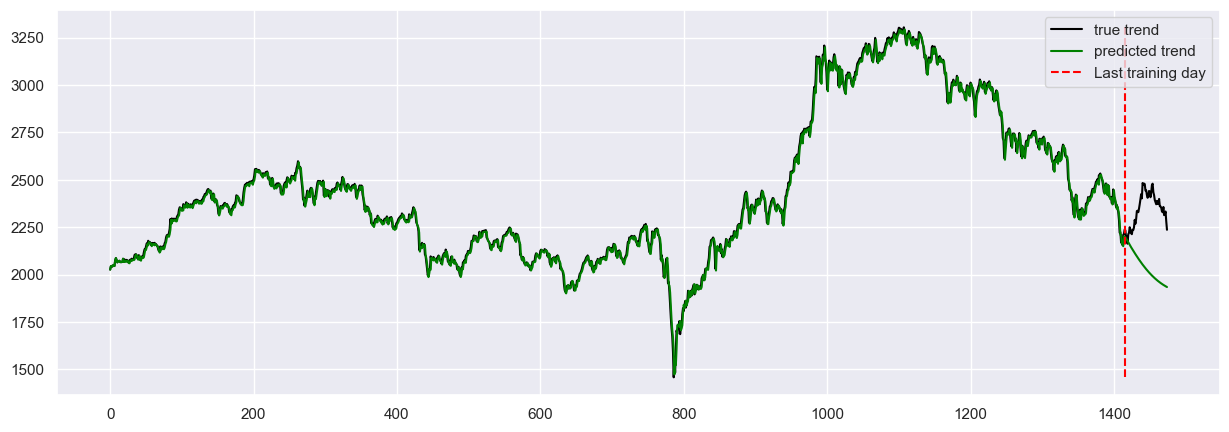

In [17]:
# accuracies = calculate_accuracy(df_adj_close.iloc[-test_size:].values, predict[-test_size:])

plt.figure(figsize = (15, 5))
plt.plot(df_adj_close.values, label = 'true trend', c = 'black')
plt.plot(predict, label = 'predicted trend', c = 'green')
# plot vertical line as the last position of training set
plt.vlines(
    x = train_data.shape[0],
    ymin = np.min(df_adj_close.values),
    ymax = np.max(df_adj_close.values),
    linestyles = '--',
    colors = 'red',
    label = 'Last training day',
)
plt.legend()
# plt.title(f'KOSPI trend prediction {accuracies:.2f}')
plt.show()